# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код

batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder="postnauka_batches", 
                                        batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем

# Ваш код
model_artm = artm.ARTM(num_topics=T, 
                       topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"], 
                       class_ids={"text":1 , "author":1}, 
                       num_document_passes=1, 
                       reuse_theta=True, 
                       cache_theta=True, 
                       seed=-1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
np.random.seed(1)

dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код

model_artm.scores.add(artm.TopTokensScore(name="score_text", num_tokens=15, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name="score_author", num_tokens=15, class_id='author'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Reg', 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=['text'], 
                                                            topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='NewReg', 
                                                            tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=['text'], 
                                                            topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
key_words = []
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=' ')
    tokens = model_artm.score_tracker["score_text"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=' ')
    key_words.append(word)
    print()

sbj0:  церковь власть русь средневековый император святой римский сага князь папа король александр византийский церковный рим 
sbj1:  планета земля атмосфера солнце солнечный белый газ карлик образовываться вокруг звезда спутник вода поверхность кислород 
sbj2:  система состояние трудность двигаться частота поведение искусственный точность относительность движение переход тест час самка самец 
sbj3:  культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство переживание повседневный этика лосев глобальный 
sbj4:  право литература литературный искусство юрист должник собственность обязательство римский владение произведение писатель юридический собственник исполнение 
sbj5:  материал структура молекула свойство углерод применение вещество полимер поверхность кристалл металл электронный алмаз углеродный твердый 
sbj6:  фильм книга автор кино театр жанр кинематограф анекдот тема документ пьеса культовый академия герой екатерина 
sbj7:  смерть ритуал тер

In [13]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=' ')
    tokens = model_artm.score_tracker["score_author"].last_tokens
    for word in tokens[topic_name]:    
        print(word, end=' ')
    print()

sbj0:  Александр_Марей Фёдор_Успенский Татьяна_Бобровникова Павел_Уваров Игорь_Данилевский Алексей_Юдин Ольга_Вайнштейн Елена_Уханова Ольга_Брилева Владимир_Петрухин Елена_Браун Григорий_Бондаренко Раиса_Кирсанова Екатерина_Болтунова Ольга_Тогоева 
sbj1:  Сергей_Попов Кирилл_Еськов Дмитрий_Вибе Дмитрий_Титов Валерий_Сулейманов Зоригто_Намсараев Сергей_Наугольных Александр_Марков Наталья_Новикова Александр_Слободкин Роман_Рафиков Елизавета_Ривкина Сергей_Писарев Дмитрий_Лось Юлия_Краус 
sbj2:  Елена_Брызгалина Михаил_Пантелеев Александр_Поддьяков Владимир_Мележик Эмиль_Ахмедов Даниэль_Сельва Виталий_Пальчиков Михаил_Фейгельман Антон_Суворов Василий_Климов Юджин_Ползик Алексей_Желтиков Владимир_Редько Илья_Щуров Георгий_Шляпников 
sbj3:  Сергей_Арутюнов Алексей_Руткевич Владимир_Миронов Пётр_Турчин Татьяна_Смоктунович Андрей_Лосев Константин_Анохин Кирилл_Разлогов Дмитрий_Иванов Фёдор_Гиренок Александр_Кислов Павел_Степанцов Павел_Умрюхин Светлана_Кузнецова Андрей_Лукашов 
sbj4:  Дмитрий

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = key_words   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids="author")
print(theta.shape)
print(phi_a.shape)

(30, 1728)
(539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

/Users/mbp_kirill/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


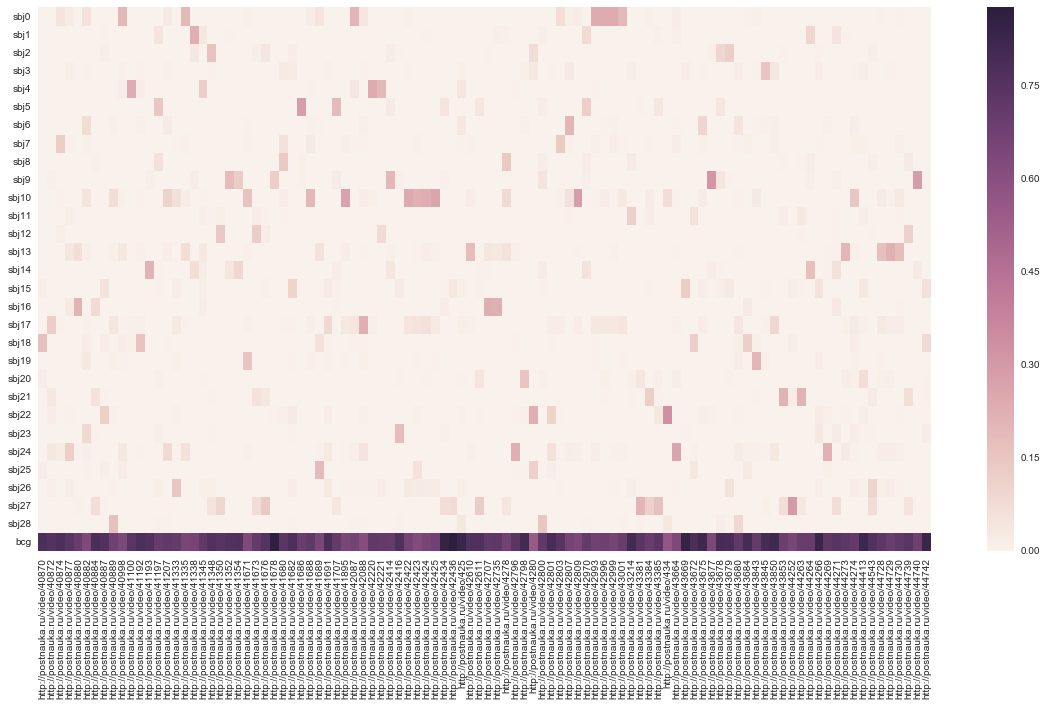

In [16]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(theta[theta.columns[:100]])
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [17]:
# Ваш код
pt = pd.DataFrame({'pt': (theta.sum(axis=1) / theta.sum(axis=1).sum()).as_matrix()} , index=topic_labels[:-1])
print(pt.sort_values(by='pt'))

                     pt
европеоид      0.004229
биоэтика       0.004614
сопротивление  0.005717
костюм         0.005982
екатерина      0.006314
сосуд          0.006418
микробный      0.006735
печень         0.007680
самец          0.008056
цифровой       0.008098
исполнение     0.008410
нарушение      0.008547
устный         0.008965
жест           0.009213
высказывание   0.009907
твердый        0.010261
ресурс         0.010656
рим            0.011114
кислород       0.011563
компьютерный   0.011954
глобальный     0.012852
химик          0.013165
китайский      0.014020
военный        0.014651
дух            0.015158
андрей         0.015320
скопление      0.018484
нейтрино       0.021004
молекулярный   0.023717
один           0.687197


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

/Users/mbp_kirill/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


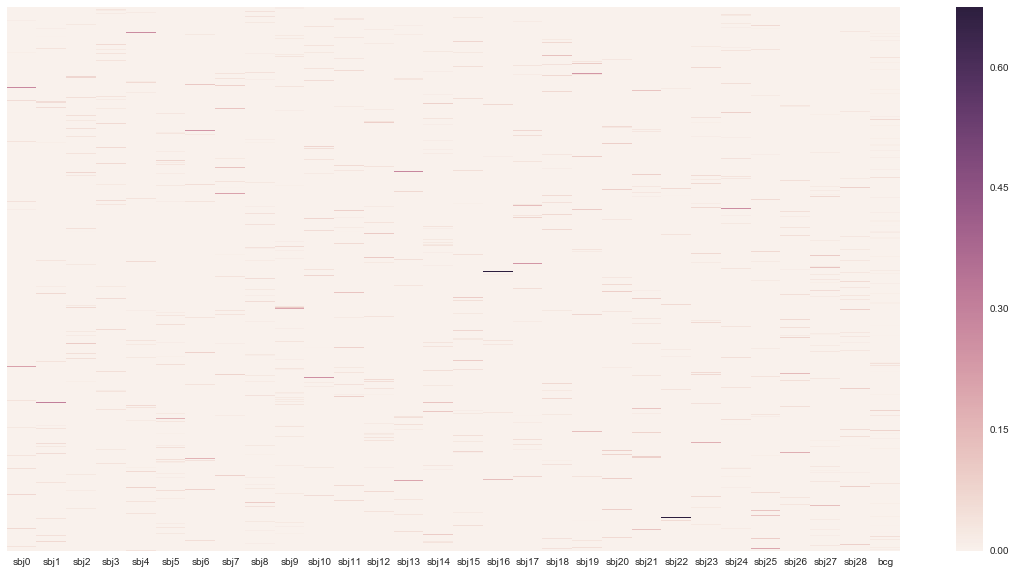

In [18]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, yticklabels=False)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [19]:
a_cnts = phi_a[phi_a > 0.01].dropna(how='all').count(axis=1, numeric_only=True)
print(a_cnts.sort_values())

Дэвид_Гросс              1
Роман_Рафиков            1
Владимир_Спиридонов      1
Сергей_Кетов             1
Даниэль_Сельва           1
Владик_Аветисов          1
Александр_Четверин       1
Владимир_Польшаков       1
Антон_Суворов            1
Алексей_Бартошевич       1
Сергей_Науменко          1
Алексей_Орлов            1
Михаил_Гельфанд          1
Дэвид_Вайнберг           1
Ольга_Исупова            1
Олег_Верходанов          1
Антон_Бернс              1
Наталья_Берлофф          1
Мартин_Вейс              1
Алексей_Белянин          1
Алексей_Касьян           1
Хопи_Хукстра             1
Мария_Шутова             1
Николай_Мощевитин        1
Александра_Скрипченко    1
Яков_Тестелец            1
Александр_Войскунский    1
Евгений_Гудилин          1
Фёдор_Успенский          1
Павел_Лушников           1
                        ..
Фуад_Алескеров           2
Нина_Сумбатова           2
Олег_Ауров               2
Валерий_Рубаков          2
Варвара_Добровольская    2
Алексей_Юдин             2
М

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [20]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [21]:
# Ваш код
pta = np.zeros(phi_a.shape)
total = 0
for i in range(phi_a.shape[0]):
    for j in range(phi_a.shape[1]):
        total += phi_a.iloc[i,j] * pt.iloc[j]
for i in range(phi_a.shape[0]):
    for j in range(phi_a.shape[1]):
        pta[i,j] = (phi_a.iloc[i,j] * pt.iloc[j]) / total
        
model = MDS(dissimilarity="precomputed", n_components=2)
model.fit(pairwise_distances(pta, metric='cosine'))

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=1, random_state=None, verbose=0)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

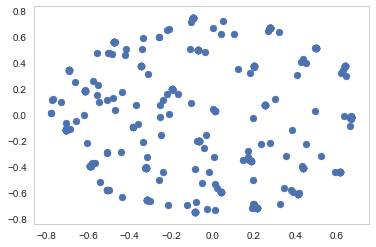

In [22]:
# Ваш код
plt.scatter(model.embedding_[:,0],model.embedding_[:,1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код

plt.figure(figsize=(15, 15))
plt.scatter(model.embedding_[:,0],model.embedding_[:,1], c=colors[np.argmax(pta, axis=1)] , s = 100)
for i in range(model.embedding_.shape[0]):
    plt.annotate(phi_a.index[i], (model.embedding_[i,0], model.embedding_[i,1]))
    
plt.savefig('postnauka.pdf', format='pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код
doc = theta / np.sum(theta)
doc_ind = (np.array(doc)).argsort(axis = 1)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print("http://yandex.ru")   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [ ]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код
for i in range(len(model_artm.topic_names)):
    topic_name = model_artm.topic_names[i]
    display(HTML("<h1>" + topic_labels[i] + "</h1>"))
    tokens = model_artm.score_tracker["score_text"].last_tokens
    for j in range(0,10):
        display(HTML('<font color="green">' + tokens[topic_name][j] + '</font>'))
    for k in range(1,11):
        print(doc.columns[doc_ind[i][-k]])

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 